<h3>Introduction and Rationale</h3>

Dear reviewer,

Thank you for your consideration. This notebook contains a time series forecast model for the BA.L stock. It should be noted that when approaching time series forecasts, a stationary series is a prerequisite for most models. Stock prices are charachteristically non-stationary, and I should ackowledge that these models would not be suitable for a rigorous quantitative trading approach. The rationale behind approaching this submission as I have is to demonstrate three main competencies:

1) To demonstrate knowledge of sk learn, as this package was referenced by name in the job posting.


2) To share perspective on my methodology for approaching modelling tasks.


3) To demonstrate statistical competency, as seen in the ARIMA model tuning section.

To demonstrate I can build a model that produces immediatly actionable results, usable in a real-world scenario, please refer to my additional submission on landslide classification. When building that model, I had more time to research variables, designed a far more sophisticated model, and evaluated its performance metrics in greater detail. The comparative simplicity of this approach is on account of the reasons listed above, as well as time constraints (I am in the process of publishing my masters dissertation alongside this application process). 

Thank you.

<h3>Overview and Contents</h3>

The generall approach to modelling this time series was to build a <b>weighted average ensemble model</b> comprised of three time series forecasting models, an ARIMA model, a Naive forecast, and a K-Nearest Neighbors model, modified via sk time to be applicable to time series data. 

The hyperparameters for the ARIMA model can be calculated automatically, although they are here calculated "by hand" for the sake of demonstration. The hyperparameters for the naive and KNN models, given the comparativley small search space, are tuned using an exhaustive grid search approach.

The results from all three models are the weighted according to the normalised value of thier inverse MSE (the performance metric used in this example, chosen over MAE to more harshly penalize errors), and a weighted average of thier predictions is used as the prediction of the ensemble model. 

Findings: ARIMA and naive appraches were significantly more suitable for this task. The KNN approach performed so poorly that it hampered the performance of the ensemble. While the KNN approach is good at factoring in <b>periodicity</b>, it is unable to adequatley factor <b>trend</b> into its predictions. 

Contents:
    
1) Preparation and Utilities

2) Determining ARIMA model parameters

3) Gridsearch for optimal Naive and KNN Hyperparameters

4) Build Ensemble Model

5) Visualise Results

<h1>1. Preparation and Utilities</h1>

<h2>1.1 Preparation</h2>

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Typically, I would never ignore warnings, but in this case there are some future warnings about packages that
# are being updated in the near future, and a warning about the Naive hyperparameter optimization that does
# NOT affect result (examined later). None of the warnings impact results. I have removed them to 
# improve the readbility of this notebook. Feel free to comment out the below if you are interested in seeing
# the warnings.

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("BA.L.csv") 

In [3]:
data = data["Close"]
data.describe()

count    139.000000
mean     507.527338
std       21.272099
min      462.100006
25%      493.849991
50%      504.399994
75%      526.300018
max      544.000000
Name: Close, dtype: float64

In [4]:
# of the 139 records, 100 will be used to train the models, with the remaining 39 used for testing. 
train = data[:100]
test = data[100:]

<h2>1.2 Defining Utilities</h2>

In [5]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

def forecast_knn(train, test, n_neighbor, window_len):
    
    regressor = KNeighborsRegressor(n_neighbors=n_neighbor)
    knn_model = make_reduction(regressor, scitype='infer', window_length=window_len, strategy="recursive")
    forecast_horizon = np.array(np.arange(len(test)) + 1)
    knn_model.fit(train)
    y_pred = knn_model.predict(forecast_horizon)
    
    return y_pred

In [6]:
from sktime.forecasting.naive import NaiveForecaster

def forecast_naive(train, test, forecast_strategy, seasonal_periodicity):
    
    naive_model = NaiveForecaster(strategy=forecast_strategy, sp=seasonal_periodicity)
    naive_model.fit(train)
    forecast_horizon = np.arange(len(test)) + 1
    y_pred = naive_model.predict(forecast_horizon)
    
    return y_pred

In [7]:
def forecast_arima(train, test, p, q, d):
    
    model = ARIMA(train, order=(p, q, d))
    result=model.fit(disp=0)
    remaining_records = len(test)
    y_pred, std_err, confidence = result.forecast(len(test))
    
    return y_pred, std_err, confidence

In [8]:
def grid_search(train, test, combinations, model):
    best_result  = 1e4
    best_combination = []
    
    for i in combinations:
        prediction = model(train, test, i[0], i[1])
        result = mean_squared_error(test, prediction)
        if result < best_result:
            best_result = result
            best_combination = i
    
    print("Lowest MSE: ", best_result)
    print("Corresponding parameters: ",best_combination)

In [9]:
def produce_weighted_predictions(predictions, weight):
    weighted_predictions = []
    for i in predictions:
        prediction = i * weight
        weighted_predictions.append(prediction)
    return weighted_predictions

<h1>2. Determining ARIMA Model Parameters</h1>

The three paramters of the Auto Resgressive Integrated Moving Average Model are:

1) p, The number of lag observations

2) d, The number of times the data has been differenced

3) q, The size of the moving average window

Use the augmented Dickey-Fuller test to determine is the series is stationary, results (p-value) indicate is is not, so differencing will be required. 

In [10]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.949864
p-value: 0.308979


In [11]:
from statsmodels.graphics.tsaplots import plot_acf

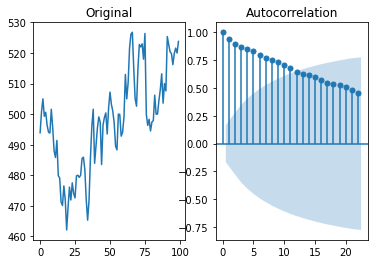

In [12]:
# Due to an error in statsmodels, this plots a repeat o
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(train)
ax1.set_title("Original")
plot_acf(data, ax=ax2);

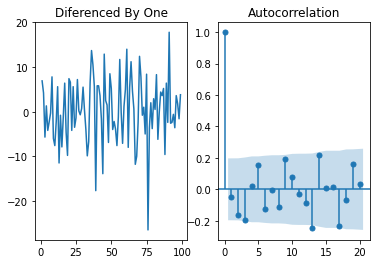

In [13]:
# difference the data once
diff_data = train.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(diff_data)
ax1.set_title("Diferenced By One")
plot_acf(diff_data, ax=ax2);

In [14]:
# Differencing once seems to have, in general, made the series more stationary. Use the ndiffs function to verify.
from pmdarima.arima.utils import ndiffs
ndiffs(train, test="adf")

1

This means the d parameter will be 1, additionally, the 3rd bar of the ACF function is the first to verge on significance, so p = 3

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf

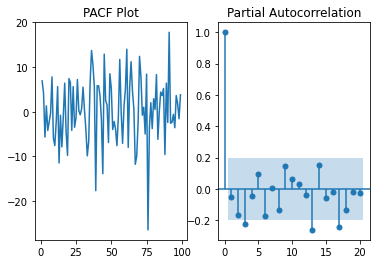

In [16]:
diff_data

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(diff_data)
ax1.set_title("PACF Plot")
plot_pacf(diff_data, ax=ax2);

Even though the 3rd bar of the ACF if the first to be significant, some trial and error either side of that number, as well as testing 13 (these approaches are common when visually determining ARIMA parameters) indicated that q = 2

In [17]:
from statsmodels.tsa.arima_model import ARIMA

In [19]:
model = ARIMA(train, order=(3, 1, 2))
result=model.fit(disp=0)

# a future warning will appear here if warnings are enabled, it does not impact the results. 

/Users/quintonaguilera/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [20]:
remaining_records = len(test)
forecast, std_err, confidence =result.forecast(remaining_records)

In [21]:
forecast = pd.Series(forecast, index=test[:remaining_records].index)
lower_bound = pd.Series(confidence[:, 0], index=test[:remaining_records].index)
upper_bound = pd.Series(confidence[:, 1], index=test[:remaining_records].index)

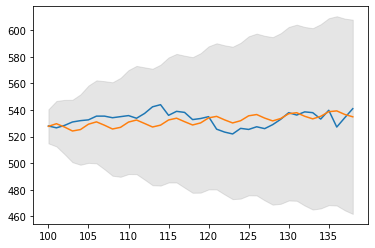

In [22]:
plt.plot(test[:remaining_records])
plt.plot(forecast)
plt.fill_between(forecast.index, lower_bound, upper_bound, color="grey", alpha=0.2)

The prediction follows the test results reasonably closely, and is within the 95% margin of error. 

In [23]:
print("MSE: ", mean_squared_error(test[:remaining_records], forecast))

MSE:  44.85008612132731


<h1>3. Gridsearch for Optimal Naive and KNN Hyperparameters</h1>

In [24]:
max_neighbors = 10
max_window_length = 10

knn_graph_x = []
for i in range(1, max_neighbors+1):
    knn_graph_x.append(i)
        
knn_graph_y = []
for i in range(1, max_window_length+1):
    knn_graph_y.append(i)

knn_grid = []  

for i in knn_graph_x :        
    for j in knn_graph_y :            
        knn_grid.append((i, j))

In [25]:
forecast_strategy = ['last', 'mean', 'drift']
max_seasonal_periodicity = 10

nf_graph_x = forecast_strategy

nf_graph_y = []
for i in range(1, max_seasonal_periodicity+1):
    nf_graph_y.append(i)

nf_grid = []   

for i in nf_graph_x :        
    for j in nf_graph_y :            
        nf_grid.append((i, j ))

In [26]:
grid_search(train, test, knn_grid, forecast_knn)

Lowest MSE:  115.15924143639623
Corresponding parameters:  (1, 10)


In [27]:
grid_search(train, test, nf_grid, forecast_naive)

# If warnings have been turned on, you will see that if "drift" is used as the forecast strategy, the model ignores
# the seasonal periodicity input. It is not an issue if you pass drift alongside a periodicty value, the 
# warning is simply to indicate that ther periodivity value is not being considered. Given more time I would 
# build my functions around this peculiarity, but for the purposes of this demonstration, and given the very short
# training time, it is not an issue. 

Lowest MSE:  48.59474810241342
Corresponding parameters:  ('drift', 1)


/Users/quintonaguilera/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/sktime/forecasting/naive.py:123: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn("For the `drift` strategy, the `sp` value will be ignored.")
/Users/quintonaguilera/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/sktime/forecasting/naive.py:123: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn("For the `drift` strategy, the `sp` value will be ignored.")
/Users/quintonaguilera/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/sktime/forecasting/naive.py:123: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn("For the `drift` strategy, the `sp` value will be ignored.")
/Users/quintonaguilera/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/sktime/forecasting/naive.py:123: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn("For the `drift` strategy, the `sp` value will be

<h1>4. Build Ensemble Model</h1>

In [33]:
knn_pred = forecast_knn(train, test, 1, 10)
nf_pred  = forecast_naive(train, test, 'drift', 1)
arima_pred, se, conf = forecast_arima(train, test, 3, 1, 2)

# a future warning will appear here if warnings are enabled, it does not impact the results. 

/Users/quintonaguilera/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/quintonaguilera/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureW

In [34]:
inverse_knn_mse   = 1/(mean_squared_error(test, knn_pred))
inverse_nf_mse    = 1/(mean_squared_error(test, nf_pred))
inverse_arima_mse = 1/(mean_squared_error(test, arima_pred))

inverse_mse_list = [inverse_knn_mse, inverse_nf_mse, inverse_arima_mse]

normalised_list = [float(i)/sum(inverse_mse_list) for i in inverse_mse_list]


In [35]:
knn_w   = produce_weighted_predictions(knn_pred, normalised_list[0])
nf_w    = produce_weighted_predictions(nf_pred, normalised_list[1])
arima_w = produce_weighted_predictions(arima_pred, normalised_list[2])

ensemble_pred = []

for (i, j, k) in zip(knn_w, nf_w, arima_w):
    prediction = i+j+k
    ensemble_pred.append(prediction)

In [36]:
mean_squared_error(test, ensemble_pred)

47.56864155914935

In [37]:
ensemble_pred = pd.Series(ensemble_pred, index=test[:len(test)].index)
arima_pred = pd.Series(arima_pred, index=test[:len(test)].index)

<h1>5. Visualize Results</h1>

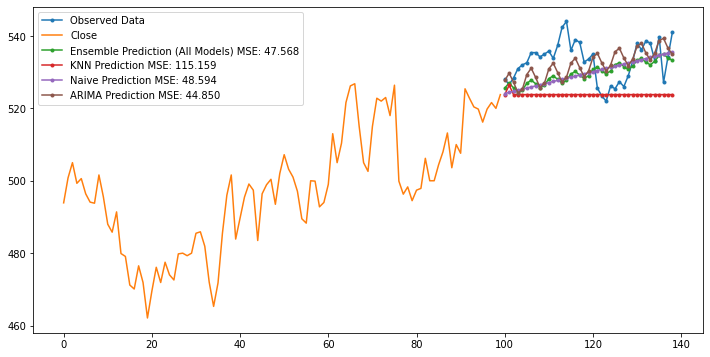

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
test.plot(ax=ax, label='Observed Data', style='.-')
train.plot()
ensemble_pred.plot(ax=ax, label='Ensemble Prediction (All Models) MSE: 47.568', style='.-')
knn_pred.plot(ax=ax, label='KNN Prediction MSE: 115.159', style='.-')
nf_pred.plot(ax=ax, label='Naive Prediction MSE: 48.594', style='.-')
arima_pred.plot(ax=ax, label='ARIMA Prediction MSE: 44.850', style='.-')
plt.legend()

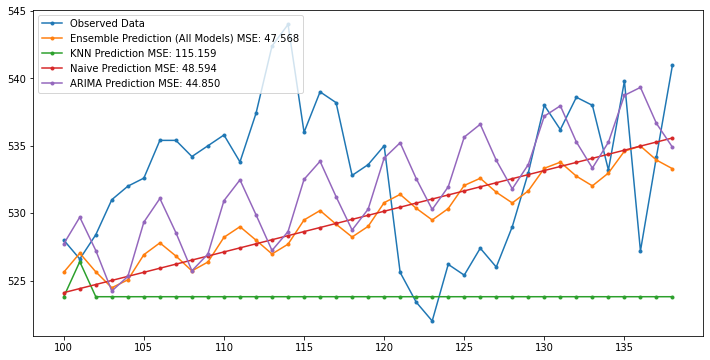

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
test.plot(ax=ax, label='Observed Data', style='.-')
ensemble_pred.plot(ax=ax, label='Ensemble Prediction (All Models) MSE: 47.568', style='.-')
knn_pred.plot(ax=ax, label='KNN Prediction MSE: 115.159', style='.-')
nf_pred.plot(ax=ax, label='Naive Prediction MSE: 48.594', style='.-')
arima_pred.plot(ax=ax, label='ARIMA Prediction MSE: 44.850', style='.-')
plt.legend()

In [40]:
mean_squared_error(test, arima_pred, squared=False)

6.697020689928269

The ARIMA model performs the best, and the failure of other models to perform at a similar level has meant that the ensemble model underperforms the ARIMA model used on its own. The ARIMA model's RMSE is ~6.7, meaning it is typically around £7 off the observed price. This is significantly lower than the standard deviation (of £21.2, calculated in section 1) although as it relates to market forecasting generally, this is still not an excellent result. A more sophisticated model incorporating more variables and able to consider macroeconomic trends, and in the case of this short window, micro level market trends,  would likely produce a better result.